# UniversityHack 2021 - Atmira Stock Prediction - Script Exploración
-----
## Resumen observaciones
* Los datos de entrenamiento han sido alterados de múltiples maneras y de forma inhomogénea, lo cuál da un grado imporante de ambigüedad al problema, ya que no está claro cuál de los patrones seguirán los datos a predecir.
* Las fechas de los datos són erróneas, las observaciones no corresponden a los años 2015-2016 sino a 2018-2019. Esto es crucial ya que el año 2016 fue bisiesto y tener un día más generaba patrones diferentes de comportamiento desfasados en función del día de la semana.
* La variable "visitas" del fichero "Modelar" ha sido multiplicada por 5 pero sólo a partir del 25 de enero. La del fichero "Estimar" también.
* La variable "unidades_vendidas" del fichero "Modelar" ha sido multiplicada por un factor 3.
* La variable "antiguedad" no cambia con el tiempo, es una característica estática de los productos. Es decir, los productos no envejecen un día después que haya pasado un día. Además, no tienen el mismo valor para los dos ficheros, tienen un desfase.
* Los fines de semana y los festivos no asociados a compra de regalos muestran una disminución de las visitas y las ventas.
-----

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Importación de los datos de entrenamiento con los precios ya añadidos

In [5]:
df = pd.read_csv(
    './data/Modelar_UH2021_filled_precio.txt', parse_dates=[1], index_col=0
)

In [6]:
df_est = pd.read_csv(
    './data/Estimar_UH2021_filled_precio.txt', parse_dates=[1], index_col=0
)

In [7]:
# Establecimos el tipo de variable adecuada
df["antiguedad"] = df["antiguedad"].astype('Int64')
df["categoria_dos"] = df["categoria_dos"].astype("Int64")
df_est["antiguedad"] = pd.to_numeric(df_est["antiguedad"], errors='coerce') 
df_est["antiguedad"] = df_est["antiguedad"].astype('Int64')
df_est["categoria_dos"] = pd.to_numeric(df_est["categoria_dos"], errors='coerce') 
df_est["categoria_dos"] = df_est["categoria_dos"].astype("Int64")

In [8]:
# Eliminamos entradas duplicadas y con NaNs
df = df.drop_duplicates()
df_est = df_est.drop_duplicates()

df = df.dropna(subset=["fecha", "id", "unidades_vendidas"])
df_est = df_est.dropna(subset=["fecha", "id"])

In [9]:
# Añadimos el día, mes, y día de la semana
df["day"] = df["fecha"].dt.day
df_est["day"] = df_est["fecha"].dt.day
df["month"] = df["fecha"].dt.month
df_est["month"] = df_est["fecha"].dt.month

df["weekday"] = df["fecha"].dt.weekday
df_est["weekday"] = df_est["fecha"].dt.weekday

## Categorías

In [10]:
list_categoria_uno = sorted(df["categoria_uno"].unique())
print("Total categoria_uno:", len(list_categoria_uno))
print("Total categoria_dos:", len(df["categoria_dos"].unique()),)

suma_categories = 0
for index in range(len(df["categoria_uno"].unique())):
    print("\nCategoria uno", list_categoria_uno[index], "\nNúmero de categorias dos:", 
          len(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique()))
    print( list(sorted(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique() ) ))
    suma_categories += len(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique())

print("\nSuma de categorías dos: ", suma_categories)

Total categoria_uno: 13
Total categoria_dos: 183

Categoria uno A 
Número de categorias dos: 35
[16, 23, 28, 34, 37, 43, 46, 67, 69, 82, 85, 103, 127, 133, 137, 145, 188, 197, 201, 236, 237, 238, 242, 245, 255, 263, 271, 282, 286, 295, 304, 338, 342, 343, nan]

Categoria uno B 
Número de categorias dos: 5
[57, 92, 153, 224, 312]

Categoria uno C 
Número de categorias dos: 12
[63, 65, 66, 72, 73, 75, 76, 157, 158, 160, 161, 170]

Categoria uno D 
Número de categorias dos: 1
[264]

Categoria uno E 
Número de categorias dos: 57
[10, 22, 30, 32, 44, 49, 50, 51, 78, 80, 93, 105, 108, 109, 114, 115, 122, 124, 125, 135, 143, 144, 150, 152, 156, 171, 175, 179, 186, 199, 200, 202, 205, 216, 229, 230, 233, 247, 248, 249, 266, 267, 268, 269, 273, 274, 275, 276, 277, 285, 305, 308, 314, 315, 319, 323, nan]

Categoria uno F 
Número de categorias dos: 9
[20, 97, 203, 217, 228, 333, 336, 341, nan]

Categoria uno G 
Número de categorias dos: 11
[29, 39, 42, 123, 155, 207, 221, 235, 253, 270, 298]

Cat

/home/muriel/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/muriel/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


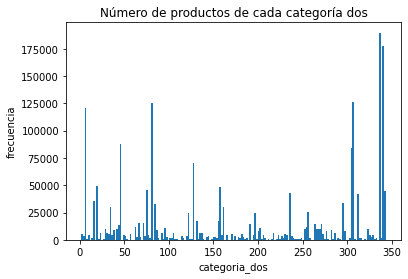

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[6,4])

axs.hist(df["categoria_dos"], bins=183)
tal = axs.set(xlabel="categoria_dos", ylabel="frecuencia", title="Número de productos de cada categoría dos")

### Productos en cada categoria uno

[('A', 678847.0),
 ('B', 51662.0),
 ('C', 163670.0),
 ('D', 3911.0),
 ('E', 161012.0),
 ('F', 280477.0),
 ('G', 84512.0),
 ('H', 199699.0),
 ('I', 36668.0),
 ('K', 320434.0),
 ('L', 53277.0),
 ('N', 4387.0)]

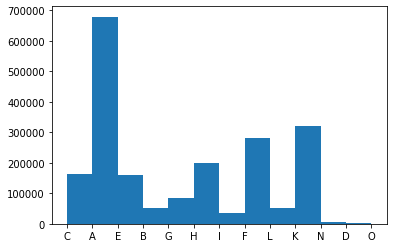

In [12]:
# Primero agrupo por categorías i después por productos
agrupat_productes = df.groupby(["categoria_uno", "id"]).sum().sort_values(["categoria_uno", "categoria_dos"])

items_in_categoria = plt.hist(df.categoria_uno, bins=12)[0]
sorted(list(zip(df["categoria_uno"].unique(),items_in_categoria)))

## Relación entre parejas de variables

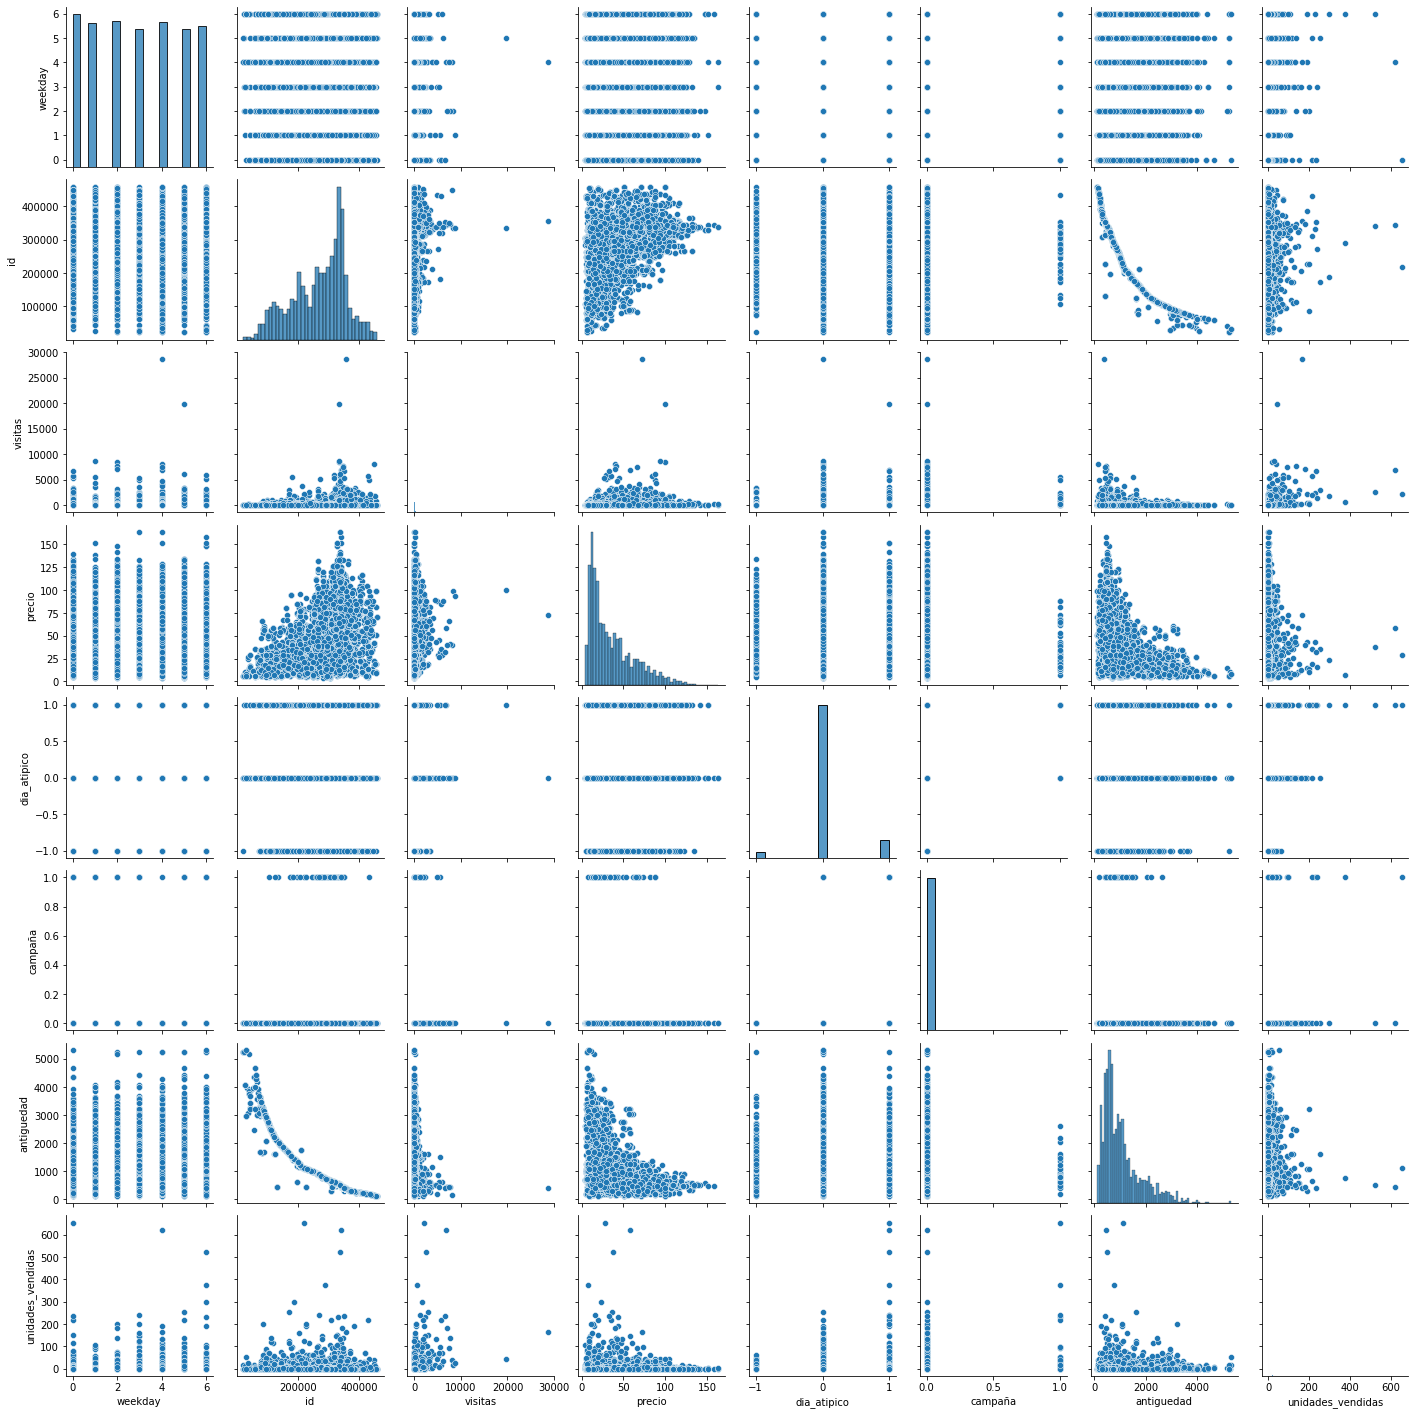

In [10]:
sns.pairplot(df.loc[:, ["weekday", "id", "visitas", "estado", "precio", "dia_atipico", "campaña", "antiguedad", 
                     "unidades_vendidas"]].sample(n=10000))

## Visitas i ventas en función de la fecha

In [13]:
# Agrupamos los datos por fecha
data_mean_total = df.groupby('fecha').mean().sort_values('fecha')
data_est_mean_total = df_est.groupby('fecha').mean().sort_values('fecha')

data_sum_total = df.groupby('fecha').sum().sort_values('fecha')
data_est_sum_total = df_est.groupby('fecha').sum().sort_values('fecha')

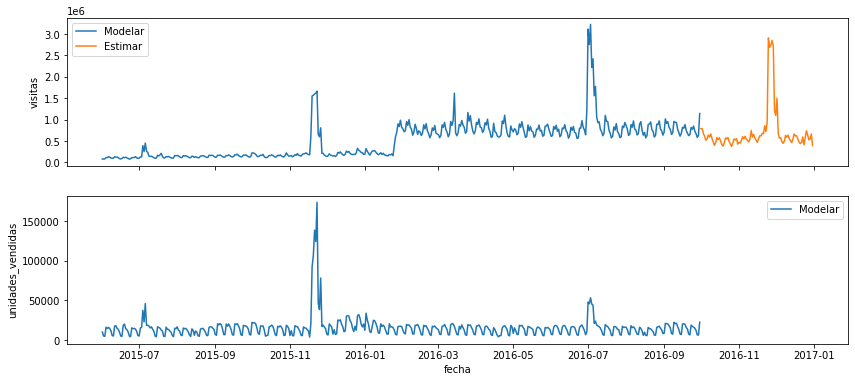

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[14,6])

axs[0].plot(data_sum_total["visitas"])
axs[0].plot(data_est_sum_total["visitas"])
axs[0].set(ylabel="visitas")
axs[0].legend(["Modelar", "Estimar"])

axs[1].plot(data_sum_total["unidades_vendidas"])
axs[1].set(ylabel="unidades_vendidas", xlabel="fecha")
axs[1].legend(["Modelar"])

#### Observaciones
* Observamos un **salto en las visitas** anòmalo en los datos de entrenamiento entre el 24 y el 25 de enero que **NO se corresponde** con un **aumento de las ventas**.
* Además, según [esta referencia](https://sonitron.net/pccomponentes-pcdays-2019/), PcComponentes registraba una media de **350.000 visitas diarias** (en 2019), lo cuál está más acorde con el valor de antes del salto que con el valor de después del salto.

## Último dígito en el número de visitas
Analizamos el último dígito del número de la variable "visitas" para detectar posibles anomalías.

In [15]:
df["visitas_digito"] = df["visitas"] % 10
df_est["visitas_digito"] = df_est["visitas"] % 10

In [16]:
df_before = df[df.fecha <= datetime.datetime(2016,1,24)]
df_after = df[df.fecha > datetime.datetime(2016,1,24)]

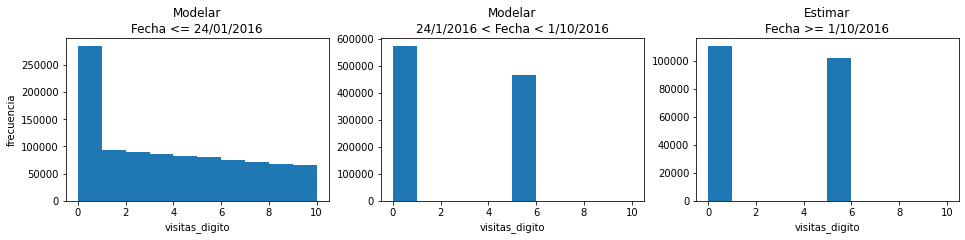

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[16,3])
axs[0].set(xlabel="visitas_digito", ylabel="frecuencia", title="Modelar\nFecha <= 24/01/2016")
axs[1].set(xlabel="visitas_digito", title="Modelar\n24/1/2016 < Fecha < 1/10/2016")
axs[2].set(xlabel="visitas_digito", title="Estimar\nFecha >= 1/10/2016")

fig1 = axs[0].hist(df_before["visitas_digito"], bins=np.arange(0,11,1) ) 
fig2 = axs[1].hist(df_after["visitas_digito"], bins=np.arange(0,11,1))
fig2 = axs[2].hist(df_est["visitas_digito"], bins=np.arange(0,11,1))

#### Observaciones 
* En el caso de los datos hasta el 24 de enero obtenemos la distribución esperada. Muchos productos que no han tenido ninguna visita contribuyen al 0 y el resto de dígitos disminuyen suavemente, debido a que es más probable que más productos tengan un número bajo de visitas.
* En el caso de los datos a partir del 24 de enero vemos con sorpresa una distribución con sólo dos valores, 0 y 5, tanto para los datos del fichero Modelar como los de Estimar. Pero que las visitas sean siempre **múltiples de cinco, NO es un comportamiento orgánico** de esta variable, e indica que las visitas **han sido multiplicadas** por ese valor.

## Último dígito en el número de unidades vendidas
También analizamos la variable "unidades vendidas" mediante la operación modulo para detectar posibles anomalías (esta variable no se encuentra en el archivo "Estimar" porque es la que hay que predecir).

In [18]:
df["unidades_vendidas_digito"] = df["unidades_vendidas"] % 10
df["unidades_vendidas_modulo_3"] = (df["unidades_vendidas"]) % 3

In [19]:
df_before = df[df.fecha <= datetime.datetime(2016,1,24)]
df_after = df[df.fecha > datetime.datetime(2016,1,24)]

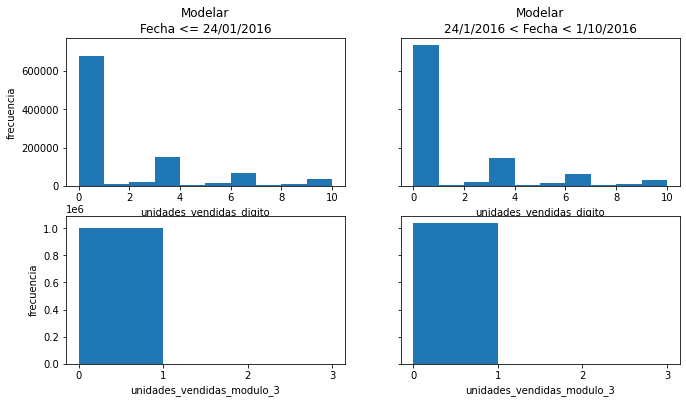

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11,6], sharey="row")

axs[0,0].set(xlabel="unidades_vendidas_digito", ylabel="frecuencia", title="Modelar\nFecha <= 24/01/2016")
axs[0,1].set(xlabel="unidades_vendidas_digito", title="Modelar\n24/1/2016 < Fecha < 1/10/2016")
axs[1,0].set(xlabel="unidades_vendidas_modulo_3", ylabel="frecuencia")
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].set(xlabel="unidades_vendidas_modulo_3")
axs[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

fig1 = axs[0,0].hist(df_before["unidades_vendidas_digito"], bins=np.arange(0,11,1))
fig2 = axs[0,1].hist(df_after["unidades_vendidas_digito"], bins=np.arange(0,11,1))
fig3 = axs[1,0].hist(df_before["unidades_vendidas_modulo_3"], bins=np.arange(0,4,1))
fig3 = axs[1,1].hist(df_after["unidades_vendidas_modulo_3"], bins=np.arange(0,4,1))

#### Observaciones 
* Tanto en los datos anteriores como los posteriores al 25 de enero encontramos una distribución también anómala. Como antes, muchos productos que no han tenido ninguna visita contribuyen al 0 pero el resto de dígitos están distribuidos de forma irregular.
* Si hacemos hacemos el módulo 3 de la variable "unidades vendidas", vemos que todos los datos dan 0. Pero que las ventas para cualquier producto sean siempre **múltiples de tres NO es un comportamiento orgánico** de esta variable e indica que las unidades vendidas **han sido multiplicadas** por ese valor.

## Visitas y ventas en función del día de la semana
Para explorar el comportamiento en función del día de la semana, **descartaremos los datos correspondientes a días especiales** en los que haya campañas publicitarias o en los que haya más o menos ventas de lo habitual, ya que podrían introducir sesgos importantes.

In [21]:
weekday_before_mean = df_before[(df_before["dia_atipico"] == 0) &
                                (df_before["campaña"] == 0)].groupby('weekday').mean().sort_values('weekday')
weekday_after_mean = df_after[(df_after["dia_atipico"] == 0) & 
                              (df_after["campaña"] == 0)].groupby('weekday').mean().sort_values('weekday')
weekday_estimar_mean = df_est[(df_est["dia_atipico"] == 0) & 
                              (df_est["campaña"] == 0)].groupby('weekday').mean().sort_values('weekday')

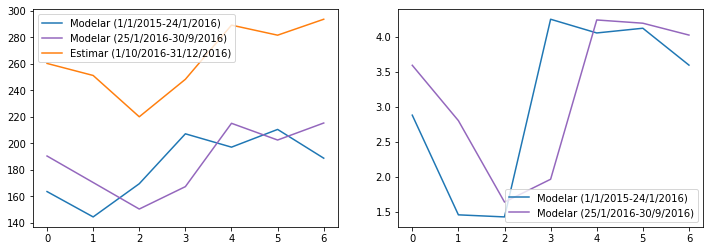

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12,4])

axs[0].plot(5*weekday_before_mean["visitas"], color="tab:blue")
axs[0].plot(weekday_after_mean["visitas"], color="tab:purple")
axs[0].plot(weekday_estimar_mean["visitas"]*1.1, color = "tab:orange")
axs[0].legend(["Modelar (1/1/2015-24/1/2016)", "Modelar (25/1/2016-30/9/2016)", "Estimar (1/10/2016-31/12/2016)"])

axs[1].plot(weekday_before_mean["unidades_vendidas"], color="tab:blue")
axs[1].plot(weekday_after_mean["unidades_vendidas"], color="tab:purple")
axs[1].legend(["Modelar (1/1/2015-24/1/2016)", "Modelar (25/1/2016-30/9/2016)"])

#### Observaciones 
* Pueden observarse **dos comportamientos diferenciados** del volumen de visitas y de ventas en función del día de la semana segun el rango de fechas.
* Los dos comportamientos tienen el mismo perfil excepto por el **desfase de un dia**, lo cual no tiene sentido y claramente se trata de un error.

## Análisis de la campaña del Black Friday
Para determinar el día de la semana real y corregir los datos, **hemos usado la campaña del Black Friday** que realiza PcComponentes cada año. Según los artículos consultados, la campaña empieza el lunes antes del Black Friday, dura toda la semana con ofertas en diferentes tipos de productos, y termina el lunes siguiente con el Cyber Monday.

<img src="../figures/black-friday_visites.png" alt='Black Friday visits' width=750>

In [23]:
# Días del mes de febrero en el fichero de datos "Modelar"
data_mean_total[data_mean_total["month"] == 2]["day"].nunique()

28

#### Observaciones

* Hemos podido determinar la fecha del Black Friday en los datos observando tanto los picos de visitas como la duración de la variable "campaña" (indicada con la flecha horizontal). Según las fechas en el archivo "Modelar" el Black Friday habría sido el 23/11/2015 y en el caso del archivo "Estimar" sería el 29/11/2016. El problema es que **el 23/11/2015 fue un lunes y el 29/11/2016 fue un martes, no viernes!!** 

* Según las referencias históricas, el 2015 y 2016 el Black Friday tuvo lugar [el 27 y 25 de noviembre](https://www.timeanddate.com/holidays/us/black-friday) respectivamente, y las campañas del Black Friday de PcComponentes fueron del [23 al 30](https://computerhoy.com/noticias/hardware/pccomponentes-anuncia-su-black-friday-2015-36947) y del [21 al 28 de noviembre](https://www.eleconomista.es/tecnologia/noticias/7945821/11/16/PcComponentes-detalla-su-Black-Friday-una-semana-completa-de-ofertas.html) así que **las fechas de los datos estan equivocadas**.

* Además, el mes de febrero que aparece en el fichero "Modelar" **sólo tiene 28 días** y el **[2016 fue un año bisiesto](https://miniwebtool.com/es/leap-years-list/)**, lo que también confirma que **los años de las fechas son erróneas**.

* Sobre las fechas reales de los datos, tanto en los años **2018-2019** como **2012-2013 [sí que tuvieron el Black Friday el 23 y 29 de noviembre](https://www.timeanddate.com/holidays/us/black-friday)**, como aparece en los datos.

* Que los años de los datasets no correspondan con las fechas reales de los datos **explica el desfase de un día en el comportamiento** en función del día de la semana observado, ya que siendo **2016 un año bisiesto** tenía un día más y ni el 2013 ni el 2019 lo fueron.

## Análisis de las visitas de Semana Santa

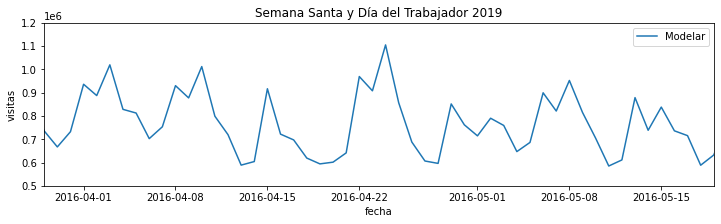

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[12,3])
axs.plot(data_sum_total["visitas"])
axs.set(xlim = (datetime.datetime(2016, 3, 29), datetime.datetime(2016, 5, 19)), ylim=(0.5e6,1.2e6),  
           xlabel="fecha", ylabel="visitas", title="Semana Santa y Día del Trabajador 2019")
axs.legend(["Modelar"])

#### Observaciones
* En 2019 la **Semana Santa** fue [del 14 al 21 de abril](https://calendarios.ideal.es/semana-santa/2019). Estas fechas coinciden con una **disminución de visitas y ventas** en los datos, que es algo que suele pasar en días festivos no asociados a hacer regalos, apoyando la tesis que **los datos corresponden al 2018-2019**. También puede observarse en la gráfica la disminución correspondiente al festivo del 1 de mayo.

 ## Análisis de la campaña de verano PcDays

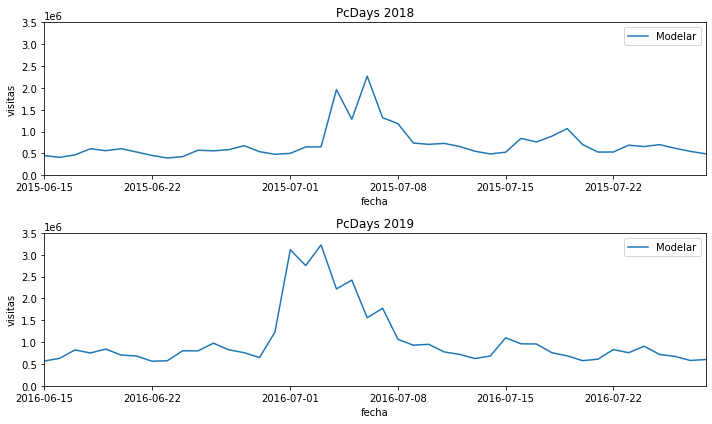

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[10,6], sharey="row")

axs[0].plot(data_sum_total["visitas"]*5)
axs[0].set(xlim = (datetime.datetime(2015, 6, 15), datetime.datetime(2015, 7, 28)),  ylim=(0,3.5e6), 
           xlabel="fecha", ylabel="visitas", title="PcDays 2018")
axs[0].legend(["Modelar"])

axs[1].plot(data_sum_total["visitas"])
axs[1].set(xlim = (datetime.datetime(2016, 6, 15), datetime.datetime(2016, 7, 28)),  ylim=(0,3.5e6), 
           xlabel="fecha", ylabel="visitas", title="PcDays 2019")
axs[1].legend(["Modelar"])
plt.tight_layout()

In [26]:
# Total de unidades vendidas durante la campaña de PCDays (en 2019)
print(data_sum_total[(data_sum_total.index >= datetime.datetime(2016, 6, 29)) & 
                     (data_sum_total.index <= datetime.datetime(2016, 7, 12))]["unidades_vendidas"].sum())

378774


#### Observaciones
* Según [su página web](https://www.pccomponentes.com/pcdays), PcComponentes celebra los PCDays, la campaña de julio, sólo desde el 2016, así que los datos **NO pueden corresponder al 2012-2013, ni tampoco al 2015-2016.**
* La campaña PcDays fue del [4 al 7 de julio en 2018](https://www.muycomputer.com/2018/07/04/pcdays-2018/) y del [30 de junio al 7 de julio en 2019](https://sonitron.net/pccomponentes-pcdays-2019/), lo cuál también coincide con el perfil de visitas de los datos.
* Según [esta otra referencia](https://sonitron.net/pccomponentes-pcdays-2019/), PcComponentes vendió 126.000 productos en su campaña PcDays del 2019. Esto es alrededor 3 veces menos de lo cantidad que se infiere de los datos del fichero "Modelar", lo cual refuerza la idea que la variable "unidades_vendidas" ha sido **multiplicada por 3.**

## Visitas y ventas en función del día de la semana (corrigiendo los años a 2018-2019)

In [ ]:
# Corregimos los años que aparecen en los datos por 2018-2019
df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
df_est.loc[df_est.fecha.dt.year == 2015, "fecha"] = df_est["fecha"] + pd.offsets.DateOffset(year=2018)
df_est.loc[df_est.fecha.dt.year == 2016, "fecha"] = df_est["fecha"] + pd.offsets.DateOffset(year=2019)

In [28]:
# Actualizamos el día de la semana
df["weekday"] = df["fecha"].dt.weekday
df_est["weekday"] = df_est["fecha"].dt.weekday

In [29]:
# Selecciono los datos de cada periodo
df_before_2018_2019 = df[df.fecha <= datetime.datetime(2019,1,24)]
df_after_2018_2019 = df[df.fecha > datetime.datetime(2019,1,24)]

# Agrupo los datos de "Modelar" en dos periodos y los de "Estimar" en otro
weekday_before_mean_2018_2019 = df_before_2018_2019[(df_before_2018_2019["dia_atipico"] == 0) &
                                               (df_before_2018_2019["campaña"] == 0)
                                              ].groupby('weekday').mean().sort_values('weekday')
weekday_after_mean_2018_2019 = df_after_2018_2019[(df_after_2018_2019["dia_atipico"] == 0) & 
                                             (df_after_2018_2019["campaña"] == 0)
                                            ].groupby('weekday').mean().sort_values('weekday')
weekday_est_mean_2018_2019 = df_est[(df_est["dia_atipico"] == 0) & (df_est["campaña"] == 0)
                                   ].groupby('weekday').mean().sort_values('weekday')

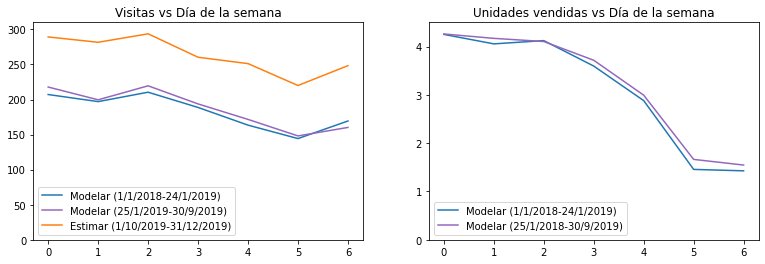

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[13,4])

axs[0].plot(5*weekday_before_mean_2018_2019["visitas"], color="tab:blue")
axs[0].plot(weekday_after_mean_2018_2019["visitas"], color="tab:purple")
axs[0].plot(weekday_est_mean_2018_2019["visitas"]*1.1, color = "tab:orange")
axs[0].set(ylim=(0,310), title="Visitas vs Día de la semana")
axs[0].legend(["Modelar (1/1/2018-24/1/2019)", "Modelar (25/1/2019-30/9/2019)", "Estimar (1/10/2019-31/12/2019)"])

axs[1].plot(weekday_before_mean_2018_2019["unidades_vendidas"], color="tab:blue")
axs[1].plot(weekday_after_mean_2018_2019["unidades_vendidas"], color="tab:purple")
axs[1].set(ylim=(0,4.5), title="Unidades vendidas vs Día de la semana")
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].legend(["Modelar (1/1/2018-24/1/2019)", "Modelar (25/1/2018-30/9/2019)"])

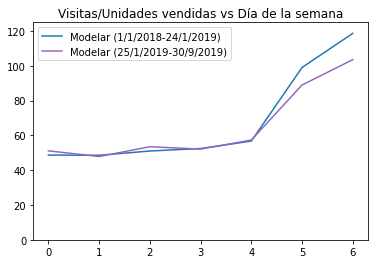

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[6,4])

axs.plot(5*weekday_before_mean_2018_2019["visitas"]/
         weekday_before_mean_2018_2019["unidades_vendidas"], color="tab:blue")
axs.plot(weekday_after_mean_2018_2019["visitas"]/
         weekday_after_mean_2018_2019["unidades_vendidas"], color="tab:purple")
axs.set(ylim=(0,125), title="Visitas/Unidades vendidas vs Día de la semana")
axs.legend(["Modelar (1/1/2018-24/1/2019)", "Modelar (25/1/2019-30/9/2019)"])

#### Observaciones 
* Al corregir el año en las fechas no sólo **ha desaparecido el desfase de un día** de comportamiento entre diferentes periodos, sinó que además también tiene mucho más sentido interpretar los datos: éstos ya no tienen un comporamiento errático sino que se hace evidente que es **el fin de semana cuando caen las visitas y las ventas** (y no los miércoles, por ejemplo).
* La ratio entre visitas y compras es la misma los días entre semana, y **aumenta el sábado y el domingo**. Días en que los clientes visitan más frecuentemente las páginas de los productos sin comprarlos.

## Tratamiento para comparar los datos de entrenamiento y de predicción

En el fichero "Estimar" hay un **subconjunto** de los productos que aparecen en el fichero "Modelar":

In [32]:
print('Productos en "Modelar": ', len(df.id.unique()) )     # 4168
print('Productos en "Estimar": ', len(df_est.id.unique()), "\n" )  # 2894

print('Productos en "Modelar" que no aparecen en "Estimar": ', 
      len(np.setdiff1d(df.id.unique(),df_est.id.unique())))
print('Productos en "Estimar" que no aparecen en "Modelar": ', 
      len(np.setdiff1d(df_est.id.unique(),df.id.unique())))

Productos en "Modelar":  4168
Productos en "Estimar":  2736 

Productos en "Modelar" que no aparecen en "Estimar":  1432
Productos en "Estimar" que no aparecen en "Modelar":  0


Para poder comparar los datos de entrenamiento i de predicción dejamos sólo los productos que aparecen en **ambos ficheros**.

In [33]:
list_products_estimar = df_est.id.unique()

# Agrupamos los datos resultantes por fecha
group_dates_red_sum = df[df.id.isin(list_products_estimar)].groupby(["fecha"]).sum()
group_dates_red_sum_est = df_est.groupby(["fecha"]).sum()

group_dates_red_mean = df[df.id.isin(list_products_estimar)].groupby(["fecha"]).mean()
group_dates_red_mean_est = df_est.groupby(["fecha"]).mean()

Ahora los datasets contienen los mismos productos, así que **la suma de las visitas debería ser comparable**

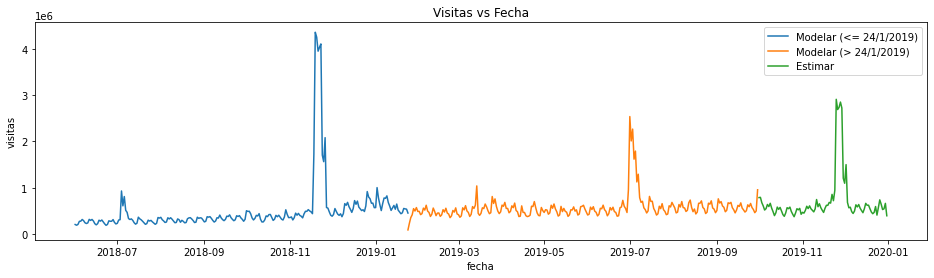

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[16,4])

axs.plot(group_dates_red_sum.loc[:datetime.datetime(2019,1,24)]["visitas"]*5)
axs.plot(group_dates_red_sum.loc[datetime.datetime(2019,1,24):]["visitas"])
axs.plot(group_dates_red_sum_est["visitas"])

axs.set(ylabel="visitas", xlabel="fecha", title="Visitas vs Fecha")
leg1=axs.legend(["Modelar (<= 24/1/2019)", "Modelar (> 24/1/2019)", "Estimar"])

## Unidades vendidas vs Visitas

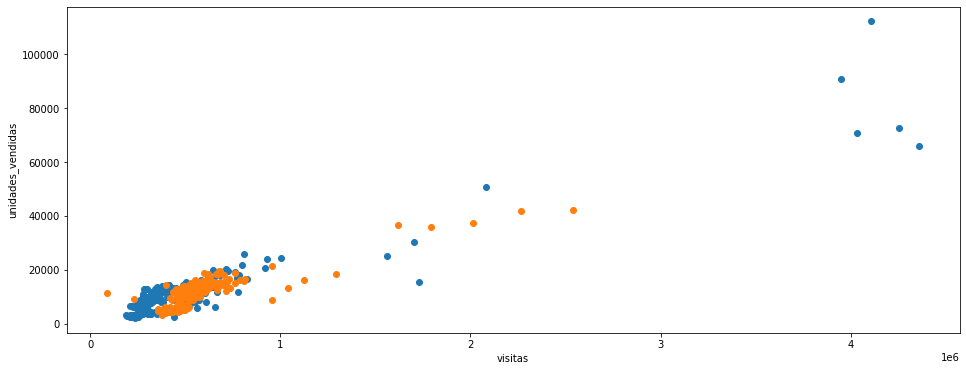

In [48]:
plt.figure(figsize=[16,6])
plt.scatter(group_dates_red_sum.loc[:datetime.datetime(2019,1,24)]["visitas"]*5, 
            group_dates_red_sum.loc[:datetime.datetime(2019,1,24)]["unidades_vendidas"])
plt.scatter(group_dates_red_sum.loc[datetime.datetime(2019,1,24):]["visitas"], 
            group_dates_red_sum.loc[datetime.datetime(2019,1,24):]["unidades_vendidas"])

labx = plt.xlabel("visitas")
laby = plt.ylabel("unidades_vendidas")